In [286]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow_decision_forests as tfdf
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

ModuleNotFoundError: No module named 'tqdm'

In [144]:
starting_directory = '.'

In [176]:
train_a = pd.read_parquet(f'{starting_directory}/A/train_targets.parquet')
train_b = pd.read_parquet(f'{starting_directory}/B/train_targets.parquet')
train_c = pd.read_parquet(f'{starting_directory}/C/train_targets.parquet')

In [281]:
X_train_estimated_a = pd.read_parquet(f'{starting_directory}/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet(f'{starting_directory}/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet(f'{starting_directory}/C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet(f'{starting_directory}/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet(f'{starting_directory}/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet(f'{starting_directory}/C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet(f'{starting_directory}/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet(f'{starting_directory}/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet(f'{starting_directory}/C/X_test_estimated.parquet')

In [282]:
sets = [X_train_observed_a, X_train_estimated_a, X_test_estimated_a, X_train_observed_b, X_train_estimated_b, X_test_estimated_b, X_train_observed_c, X_train_estimated_c, X_test_estimated_c]

constant_columns = []
set_num=0
for set in sets:
    for column in set.columns:
        # Add constant
        if set[column].nunique() == 1 and set_num == 0:
            constant_columns.append(column)
        elif set[column].nunique() != 1 and column in constant_columns:
            # Pop impostor
            constant_columns.remove(column)
    set_num += 1


print("Column", constant_columns, "removed")

Column ['elevation:m'] removed


In [283]:
# Pre-processing

def fillNaN(data):
    new_data = []
    for df in data:
        df[['ceiling_height_agl:m', 'cloud_base_agl:m']] = df[['ceiling_height_agl:m', 'cloud_base_agl:m']].interpolate()
        new_data.append(df)
    return new_data

def quartersToHours(data):
    hourly_data = []
    for df in data:
        # Round the 'date_forecast' column to nearest hour
        df['date_forecast'] = df['date_forecast'].dt.round('H')

        df_hourly_mean = df.groupby('date_forecast').mean().reset_index()

        hourly_data.append(df_hourly_mean)

    return hourly_data

def convert_date_to_sin_and_cos(data):
    new_data = []
    for df in data:
        hour = 60*60
        day = 24*60*60
        year = (365.2425)*day
        month = year / 12.0
        
        df["year"] = [df["date_forecast"][i].year for i in range(len(df))]
        df["month"] = [df["date_forecast"][i].month for i in range(len(df))]
        df["hour"] = [df["date_forecast"][i].hour for i in range(len(df))]
    
        date_time = pd.to_datetime(df.pop('date_forecast'), format='%Y-%m.%d %H:%M:%S')
        timestamp_s = date_time.map(pd.Timestamp.timestamp)
    
        df['hour_sin'] = np.sin(timestamp_s * (2 * np.pi / hour))
        df['hour_cos'] = np.cos(timestamp_s * (2 * np.pi / hour))
        df['month_sin'] = np.sin(timestamp_s * (2 * np.pi / month))
        df['month_cos'] = np.cos(timestamp_s * (2 * np.pi / month))
        df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
        df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))
        new_data.append(df)
    return new_data


def appendLabels(train, val, labels):
    # Remove hour and minute values
    # val = val.assign(date_forecast=val.date_forecast.dt.round('H'))
    # train = train.assign(date_forecast=train.date_forecast.dt.round('H'))
    
    # Rename columns names to match
    #train = train.rename(columns={'date_forecast': 'date'})
    #val = val.rename(columns={'date_forecast': 'date'})
    labels = labels.rename(columns={'time': 'date_forecast'})
    
    joined_train = pd.merge(train, labels, how="inner", on="date_forecast")
    joined_val = pd.merge(val, labels, how="inner", on="date_forecast")

    return [joined_train, joined_val]

# Remove date columns
def removeNonNumeric(data):
    numeric_data = []
    for df in data:
        non_numeric_columns = df.select_dtypes(exclude='number').columns.tolist()
        df.drop(columns=non_numeric_columns, inplace=True)
        numeric_data.append(df)
    return numeric_data

def removeNaN(data):
    new_data = []
    for df in data:
        df = df.dropna(subset=['pv_measurement'])
        new_data.append(df)
    return new_data


def validNaming(data):
    # Replace : with -
    data1 = []
    for df in data:
        data1.append(df.rename(columns=lambda x: x.replace(':', '-')))
    return data1

In [284]:
A = [X_train_observed_a, X_train_estimated_a]
B = [X_train_observed_b, X_train_estimated_b]
C = [X_train_observed_c, X_train_estimated_c]


A = quartersToHours(A)
B = quartersToHours(B)
C = quartersToHours(C)

A = appendLabels(A[0], A[1], train_a)
B = appendLabels(B[0], B[1], train_b)
C = appendLabels(C[0], C[1], train_c)

A = convert_date_to_sin_and_cos(A)
B = convert_date_to_sin_and_cos(B)
C = convert_date_to_sin_and_cos(C)

A = fillNaN(A)
B = fillNaN(B)
C = fillNaN(C)

A = removeNonNumeric(A)
B = removeNonNumeric(B)
C = removeNonNumeric(C)

A = removeNaN(A)
B = removeNaN(B)
C = removeNaN(C)

#A = validNaming(A)
#A = validNaming(B)
#A = validNaming(C)

In [285]:
# Function to find and remove sequences with 12 or more identical subsequent values
def removeSequences(data):
    new_data = []
    for df in tqdm(data):
        start_idx = None
        prev_value = None
        subsequent_count = 0
        for idx, value in enumerate(df['pv_measurement']):
            if subsequent_count >= 24:
                df = df.drop(df.index[idx-24:idx])
                subsequent_count == 0                
            
            if prev_value != None:
                if value - prev_value < 10:
                    subsequent_count += 1
            
                else:
                    prev_value = value
                    subsequent_count = 0
            else:
                prev_value = value
             
        new_data.append(df)

    return new_data


A = removeSequences(A)
B = removeSequences(B)
C = removeSequences(C)

In [ ]:
plt.plot(A[1]['month_cos'][:366*24])

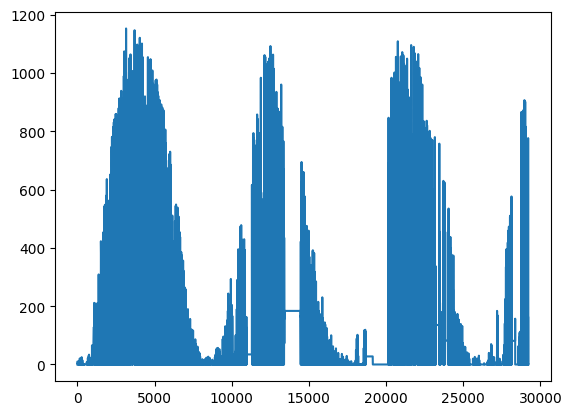

In [266]:
plt.plot(B[0]['pv_measurement'])

Use /var/folders/lt/ffct_t4x1hq9sb2k_fhds_1w0000gp/T/tmppkrdj9fl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.837112. Found 29667 examples.
Training model...


[INFO 23-10-23 15:07:39.2549 CEST kernel.cc:1243] Loading model from path /var/folders/lt/ffct_t4x1hq9sb2k_fhds_1w0000gp/T/tmppkrdj9fl/model/ with prefix 47e835c71c68400b
[INFO 23-10-23 15:07:42.4713 CEST decision_forest.cc:660] Model loaded with 300 root(s), 1241238 node(s), and 49 input feature(s).
[INFO 23-10-23 15:07:42.4714 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-10-23 15:07:42.4714 CEST kernel.cc:1075] Use fast generic engine


Model trained in 0:00:47.716272
Compiling model...
Model compiled.


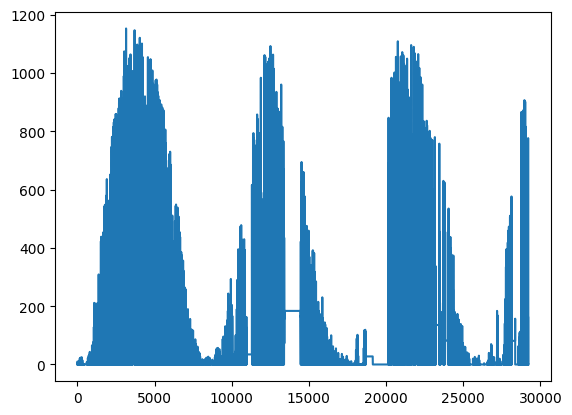

In [182]:
model_a = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)

# Convert the dataset into a TensorFlow dataset.
train_ds_a = tfdf.keras.pd_dataframe_to_tf_dataset(A[0], label='pv_measurement', task=tfdf.keras.Task.REGRESSION)

# Train a Random Forest model.
model_a.fit(train_ds_a)

In [189]:
test_ds_a = tfdf.keras.pd_dataframe_to_tf_dataset(A[1], label='pv_measurement', task=tfdf.keras.Task.REGRESSION)

# Summary of the model structure.
model_a.summary()

# Evaluate the model
#evaluate = model_a.evaluate(test_ds)
#print(f'MAE on known data: {evaluate}')

predictions_a = model_a.predict(test_ds_a)
actual_values_a = A[1]['pv_measurement']

print(np.mean(tf.keras.metrics.mean_absolute_error(
    actual_values_a, predictions_a
)))

Model: "random_forest_model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (54):
	absolute_humidity_2m:gm3
	air_density_2m:kgm3
	ceiling_height_agl:m
	clear_sky_energy_1h:J
	clear_sky_rad:W
	cloud_base_agl:m
	dew_or_rime:idx
	dew_point_2m:K
	diffuse_rad:W
	diffuse_rad_1h:J
	direct_rad:W
	direct_rad_1h:J
	effective_cloud_cover:p
	elevation:m
	fresh_snow_12h:cm
	fresh_snow_1h:cm
	fresh_snow_24h:cm
	fresh_snow_3h:cm
	fresh_snow_6h:cm
	hour
	hour_cos
	hour_sin
	is_day:idx
	is_in_shadow:idx
	month
	month_cos
	month_sin
	msl_pressure:hPa
	precip_5min:mm
	precip_type_5min:idx
	pressure_100m:hPa
	pressure_50m:hPa
	prob_rime:p
	rain_water:kgm2
	relative_humidity_1000hPa:p
	sfc_

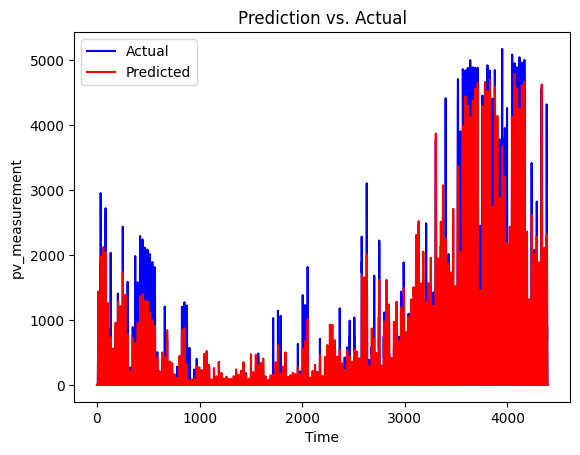

In [190]:
# Plotting Prediction vs. Actual
plt.plot(actual_values_a, label='Actual', color='blue')
plt.plot(predictions_a, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('pv_measurement')
plt.title('Prediction vs. Actual')
plt.legend()
plt.show()